# Configuración y carga del repositorio Git
La idea es que cada vez que entreno un modelo lo suba al git. Por defecto se ubica en el directorio `/content`.

In [0]:
# Borrar resultados anteriores si los hubiera
!rm -rf CMR
!rm -rf dlmi-uba

In [46]:
# !git remote add gitlab https://gitlab.com/bettachini/dlmi-uba
# !git clone gitlab
# !git push --set-upstream gitlab master

fatal: remote gitlab already exists.
fatal: repository 'gitlab' does not exist
fatal: could not read Username for 'https://gitlab.com': No such device or address


In [48]:
# !git config --global user.name "Víctor A. Bettachini"
# !git config --global user.email "victorb@gmx.net"
# Bajar las imágenes para analizar
! git clone https://gitlab.com/bettachini/dlmi-uba.git
# Info sobre cómo subir un dataset a google colab: https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9

Cloning into 'dlmi-uba'...
remote: Enumerating objects: 1687, done.
remote: Counting objects: 100% (1687/1687), done.
remote: Compressing objects: 100% (1637/1637), done.
remote: Total 1687 (delta 48), reused 1683 (delta 47)
Receiving objects: 100% (1687/1687), 32.77 MiB | 8.35 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [44]:
# !cd dlmi-uba/practica3
# !cd /content
# !cp /werk_Unet.ipynb dlmi-uba/practica3
# !cp ./model.hdf5 dlmi-uba/practica3/unet.hdf5
# !cp ./model.json dlmi-uba/practica3/unet.json
# !git add model*
# !git commit -m 'modelo unet'
# !git push gitlab

fatal: The current branch master has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream gitlab master



# Configuración del entorno y descarga de datos

Primero procedemos a ejecutar el comando que nos va a descargar en el server las imágenes a analizar.

In [1]:
# Instalar las dependencias necesarias
!pip install medpy

    100% |████████████████████████████████| 163kB 6.4MB/s 
    100% |████████████████████████████████| 7.0MB 5.0MB/s 
  Running setup.py bdist_wheel for medpy ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/6f/c0/44/15d33190c8b7b3eaa39677e9830646fac3a125ac840d17cc86
Successfully built medpy


# Visualizando algunas imágenes de ejemplo y seteando paths

Aquí seteamos algunos paths necesarios para indicar dónde se encuentran las imágenes de train, validation y test.

También visualizaremos algunas imágenes de ejemplo.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python2.7/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


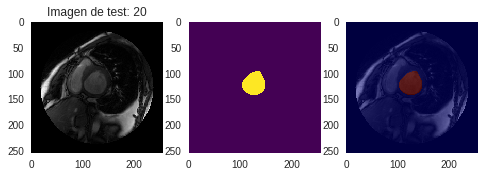

In [3]:
import matplotlib.pyplot as plt
import skimage.io as io
import os
import numpy as np
# Paths a los datos descargados

TRAIN_DATA_DIR = "dlmi-uba/practica3/data/Train/"
VAL_DATA_DIR = "dlmi-uba/practica3/data/Val/"
TEST_IMAGES_DIR = "dlmi-uba/practica3/data/Test/Images/"
TEST_LABELS_DIR = "dlmi-uba/practica3/data/Test/Labels/"

def visualizarImagenTest(imgNbr):
  # Leer el ground truth
  gt = io.imread(os.path.join(TEST_LABELS_DIR, str(imgNbr) + ".png"),as_gray = True)
  gt = gt[:,:,0].astype(np.bool).astype(np.float)

  # Leer la imagen original
  img = io.imread(os.path.join(TEST_IMAGES_DIR, str(imgNbr) + ".png"),as_gray = True)
    
  # Visualizar la imagen y el ground truth
  plt.figure()

  plt.subplot(1,3,1)
  plt.grid(False)
  plt.title("Imagen de test: " + str(imgNbr))

  plt.imshow(img, cmap='gray')

  plt.subplot(1,3,2)
  plt.grid(False)

  plt.imshow(gt, cmap = 'viridis')

  plt.subplot(1,3,3)
  plt.grid(False)
  plt.hold(True)

  plt.imshow(img, cmap='gray')
  plt.imshow(gt, cmap='jet', alpha = 0.5)
    
visualizarImagenTest(20)

# Cómputo del Dice para comparar segmentaciones

Ahora procederemos a usar el método `medpy.metrics.dc(pred, gt)` para evaluar la calidad de nuestras segmentaciones semi-automáticas.

Recordar que al método "dc" es necesario pasarle como parámetro matrices numpy.

In [0]:
import medpy.metric.binary as metrics

# U-Net para segmentación de imágenes
Ahora vamos a entrenar una red convolucional con arquitectura U-Net para segmentar una imagen.

Para entrenar el modelo, en Keras es necesario definir un generador de batches que será utilizado para fitear el modelo:

In [5]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.transform as trans

import os
def ensure_dir(directory):
  if not os.path.exists(directory):
      os.makedirs(directory)
      
def adjustData(img,mask):
    img = img / 255.
    mask = mask / 255.
    
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

def trainGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image", mask_save_prefix  = "mask",
                    save_to_dir = None, target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

def valGenerator(batch_size, train_path, image_folder, mask_folder, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image", mask_save_prefix  = "mask",
                    save_to_dir = None, target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)
        
def testGenerator(test_path,num_image = 30, target_size = (256,256), as_gray = True):
  for i in range(num_image):
        img = io.imread(os.path.join(test_path,str(i) + ".png"),as_gray = as_gray)
        img = img / 255.
        img = img[:,:,0]
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img
        
def saveResult(save_path,npyfile):
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

Using TensorFlow backend.


# Definición del modelo

Acá procedemos a definir el modelo U-Net a utilizar.

In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
    
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

  
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    
    # Implementar un U-Net que tenga:
    # - Relu como función de activación
    # - 4 niveles de MaxPooling de 2x2
    # - Que utilice 'he' como método de incialización de pesos: kernel_initializer = 'he_normal'
    
    
    # notación usual conv1_3x3@32 donde se indica el tamaño kernel y el ńumero de feature maps
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # se suele multiplicar el número de feature maps, entro con salida de pool1
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # multiplicamos el número de feature maps, entro con salida de pool2
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # multiplicamos el número de feature maps, entro con salida de pool3
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # multiplicamos el número de feature maps, entro con salida de pool4, sin pooling
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    
    # comenzamos con las upconvoluciones, como hice una upsampling de 2x2 la convolución debe ser de 2 (2x2)
    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3) # no concatena con nada la conv4
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    # comenzamos con las upconvoluciones, como hice una upsampling de 2x2 la convolución debe ser de 2 (2x2)
    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis = 3) # no concatena con nada la conv4
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    # comenzamos con las upconvoluciones, como hice una upsampling de 2x2 la convolución debe ser de 2 (2x2)
    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3) # no concatena con nada la conv4
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    # comenzamos con las upconvoluciones, como hice una upsampling de 2x2 la convolución debe ser de 2 (2x2)
    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3) # no concatena con nada la conv4
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
 
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    out = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    
    model = Model(input = inputs, output = out )

    # Compilar el modelo usando Adam como algoritmo de optimización, con learning rate = 1e-5
    model.compile(optimizer = Adam(lr=1e-5) , loss=dice_coef_loss, metrics=[dice_coef])
    
    print(model.summary())

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    print("Model created")
    return model


# Seteando el entorno para GPU

Primero, testeamos si está funcionando la GPU de Colab. Para configurarlo vamos a "Entorno de ejecución --> Cambiar tipo de entorno de ejecución" y en "Adminstrador de Hardware" elegimos "GPU".

Para ver si lo hicimos bien, corramos el siguiente snippet de código, y su salida debería ser "'/device:GPU:0'".

De no ser asi, hay algo mal que no anda bien :/

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Testeamos si estamos usando la
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Entrenar el modelo

A continuación, entrenaremos el modelo usando el método 'fit_generator' de Keras.


In [0]:
# Based on: https://github.com/zhixuhao/unet/blob/master/main.py

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Diccionario conteniendo los parámetros para la aumentación de datos

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

# Generador para los datos de training
trainGen = trainGenerator(10,TRAIN_DATA_DIR,'Images','Labels',data_gen_args,save_to_dir = None)

# Generador para los datos de test
valGen = valGenerator(8,VAL_DATA_DIR,'Images','Labels', save_to_dir = None)

model = unet()
model_checkpoint = ModelCheckpoint('unet_CMR.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(trainGen,steps_per_epoch=130, epochs=10,callbacks=[model_checkpoint], validation_data=valGen, validation_steps=7)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:87: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

# Guardando el modelo entrenado
[https://machinelearningmastery.com/save-load-keras-deep-learning-models/]
Guardo los pesos del modelo entrenado en formato HDF5

In [0]:
!pip install h5py

In [0]:
from keras.models import model_from_json

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.hdf5")
print("Saved model to disk")

Saved model to disk


## Recuperando el modelo
Se guarda  el modelo en /content en un archivo de pesos en formato hdf5 y en uno de definición en JSON.

In [20]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.hdf5")
print("Loaded model from disk")
model = loaded_model

Loaded model from disk


In [16]:
!ls

dlmi-uba  model.hdf5  model.json  sample_data


## Visualizando las curvas de entrenamiento

El objeto 'history' devuelto por el método fit_generator contiene los valores de las funciones de pérdida y de Dice durante el entrenamiento para training y validation.

Visualizar las curvas de loss y de Dice para ambos casos:

In [18]:
print(history.history.keys())

plt.figure()
plt.title("Loss vs epochs")
plt.plot( history.history['loss'],'r')
plt.plot( history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

plt.figure()
plt.title("Dice vs epochs")
plt.plot( history.history['dice_coef'],'r' )
plt.plot( history.history['val_dice_coef'] )
plt.legend(['Training Dice', 'Validation Dice'])

NameError: ignored

# Testeando el modelo y generando imágenes de salida

Una vez entrenado el modelo, procedemos a generar las predicciones sobre las imágenes de test.



In [21]:

TEST_IMAGES_DIR = "dlmi-uba/practica3/data/Test/Images/"
TEST_LABELS_DIR = "dlmi-uba/practica3/data/Test/Images/"

myGeneTest = testGenerator(TEST_IMAGES_DIR, 56)
results = model.predict_generator(myGeneTest,56,verbose=1)
ensure_dir('CMR/test/')
saveResult("CMR/test",results)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


56/56 [==============================] - 5s 85ms/step


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: CMR/test/6_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: CMR/test/7_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: CMR/test/8_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: CMR/test/9_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: CMR/test/14_predict.png is a low contrast image
  warn('%s is a low contrast 

# Visualizando resultados de test

Variando el 'imgNbr', visualizar distintos resultados y verificar el valor del Dice para cada uno de ellos.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


{'dc': 0.5420560747663551,
 'precision': 0.507201646090535,
 'recall': 0.5820543093270366,
 'sensitivity': 0.5820543093270366,
 'specificity': 0.9925953407843683}

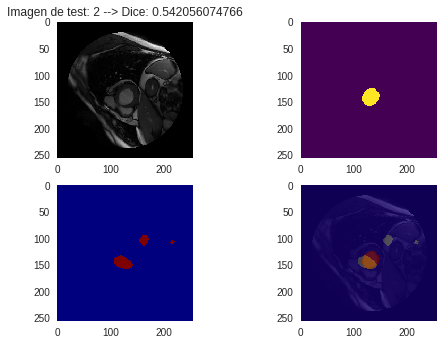

In [23]:
import matplotlib.pyplot as plt

def generarStatsTestImg(imgNbr, plotImages = True):
  TEST_IMAGES_DIR = "dlmi-uba/practica3/data/Test/Images/"
  TEST_LABELS_DIR = "dlmi-uba/practica3/data/Test/Labels/"

  # Leer la predicción guardada
  predSoft = io.imread("CMR/test/" + str(imgNbr) + "_predict.png",as_gray = True)
  predSoft = predSoft / float(np.max(predSoft))

  # Reescalar y thresholdear para reconstruir la hard segmentation
  pred = np.zeros(shape = predSoft.shape, dtype = np.float)
  pred[predSoft > 0.5] = 1

  # Leer el ground truth
  gt = io.imread(os.path.join(TEST_LABELS_DIR, str(imgNbr) + ".png"),as_gray = True)
  gt = gt[:,:,0].astype(np.bool).astype(np.float)

  # Leer la imagen original
  img = io.imread(os.path.join(TEST_IMAGES_DIR, str(imgNbr) + ".png"),as_gray = True)
    
  # Computar métricas
  stats = {}
  stats['dc'] = metrics.dc(pred, gt)
  stats['precision'] = metrics.precision(pred, gt)
  stats['recall'] = metrics.recall(pred, gt)
  stats['sensitivity'] = metrics.sensitivity(pred, gt)
  stats['specificity'] = metrics.specificity(pred, gt)
  
  
  if plotImages:
    # Visualizar la imagen, la predicción, el ground truth y todo superpuesto
    plt.figure()

    plt.subplot(2,2,1)
    plt.grid(False)
    plt.title("Imagen de test: " + str(imgNbr) + " --> Dice: " + str(stats['dc']))

    plt.imshow(img, cmap='gray')

    plt.subplot(2,2,2)
    plt.grid(False)

    plt.imshow(gt, cmap = 'viridis')

    plt.subplot(2,2,3)
    plt.grid(False)

    plt.imshow(pred, cmap='jet')

    plt.subplot(2,2,4)
    plt.grid(False)
    plt.hold(True)

    plt.imshow(img, cmap='gray')
    plt.imshow(pred, cmap='viridis', alpha=0.5)
    plt.imshow(gt, cmap='jet', alpha = 0.5)
    
  return stats

generarStatsTestImg(2, True)

# Estudio comparativo de arquitecturas

Computar las métricas para todas las imágenes de test, y generar un gráfico de Boxplot comparando el Dice coefficient para distintas variantes de la arquitectura UNet.

Algunas posibles variantes son:

1.  **Dropout**: Incorporar Dropout antes y después de la capa central (con menor resolución espacial) de la UNet.

2.   **Batch-norm**: Incorporar Batch-Normalization a la red.

3.   **Cantidad de Feature-maps**: Incrementar o reducir la cantida de feature maps, y evaluar el impacto en los resultados obtenidos.

4. **Weight-decay**: Incorporar regularización sumando en la función de pérdida la norma L2 de los pesos de la red.

5. **Conexiones residuales**: Reemplazar las concatenaciones de la U-Net por sumas, simulando módulos de conexiones residuales.

Para mostrar los resultados agregados para todo el test-set, puede utilizarse algo como el siguiente código:

## mail de Enzo del 19/12/18
Extender el práctico 3 con variantes en la arquitectura U-Net propuesta (también se puede aplicar a otros datos, buscar algún paper con alguna idea interesante y aplicarla en la UNet básica, etc). Esto tiene que venir acompañado de un informe, con un estudio comparativo de las arquitecturas propuestas y su desempeño en el dataset utilizado.

In [24]:
dices = []
showImages = False

for i in range(56):
  print("Processing image: " + str(i))
  stats = generarStatsTestImg(i, False)
  dices.append( stats['dc'] )

Processing image: 0
Processing image: 1
Processing image: 2
Processing image: 3
Processing image: 4
Processing image: 5
Processing image: 6
Processing image: 7
Processing image: 8
Processing image: 9
Processing image: 10
Processing image: 11
Processing image: 12
Processing image: 13
Processing image: 14
Processing image: 15
Processing image: 16
Processing image: 17
Processing image: 18
Processing image: 19
Processing image: 20
Processing image: 21
Processing image: 22
Processing image: 23
Processing image: 24
Processing image: 25
Processing image: 26
Processing image: 27
Processing image: 28
Processing image: 29
Processing image: 30
Processing image: 31
Processing image: 32
Processing image: 33
Processing image: 34
Processing image: 35
Processing image: 36
Processing image: 37
Processing image: 38
Processing image: 39
Processing image: 40
Processing image: 41
Processing image: 42
Processing image: 43
Processing image: 44
Processing image: 45
Processing image: 46
Processing image: 47
Pr

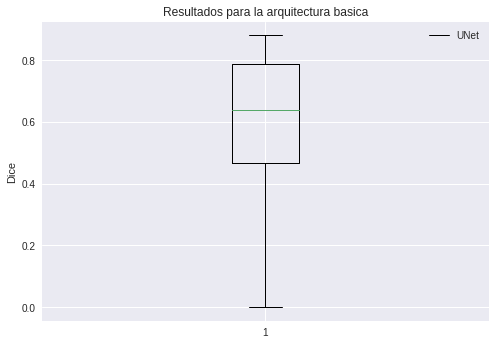

In [0]:
plt.figure()
plt.boxplot(dices)
plt.title("Resultados para la arquitectura basica")
plt.ylabel("Dice")
plt.legend(["UNet"])

Tarea para final:
  - curvas de entrenamiento
  - curvas de validación
  - probar arquitecturas
  - probar dropout

## Visualizar la red definida por Keras
[https://keras.io/visualization/]
Primero quiero dejar un registro visual de la arquitectura de la red U-Net original.

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='unet_original.png')